## Import packages

#!pip install imgaug
#!pip install opencv-python
#!pip install --upgrade scikit-image

In [1]:
import os, sys, warnings, random, tqdm, glob, pylab, numpy as np, pandas as pd

# packages for visualization
import pydicom, cv2, seaborn as sns, matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
# packages for mode
import tensorflow as tf, keras
from keras.backend.tensorflow_backend import set_session
from keras.models import load_model
from sklearn.model_selection import KFold



Using TensorFlow backend.


## 0 Setting

In [2]:
pd.set_option('display.max_columns',50)
warnings.filterwarnings("ignore")

In [3]:
# 1 Limit GPU usage
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=tf_config))
#



tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(session = tf.Session(config=tf_config))

In [4]:
# Project Diretory
os.chdir('/home/ubuntu/healthcare/pneumonia_lungfish/')

# Source Directory
src = '/home/ubuntu/healthcare/pneumonia_lungfish/src'

#Data directory
raw_data_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/data/raw'
procesed_data_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/data/processed'

#Image directory
train_dicom_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/data/raw/stage_2_train_images/'
# A list of images in the train_dicom_DIR
train_dicom = [f for f in os.listdir(train_dicom_DIR) if os.path.isfile(os.path.join(train_dicom_DIR, f))]

# Model Directory
MASK_RCNN = '/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN'
COCO_WEIGHTS_PATH = "/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN_coco_weights/mask_rcnn_coco.h5"
models_working_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/models_working'
models_save_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/models_save'

#Visulization diretory
visul_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/visualization/'
feature_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/features/'


## I. EDA of Dataframes

#### 1) Prepare a dataframe df_path listing the path for each image 

In [6]:
df_path = pd.DataFrame({'path': glob.glob(os.path.join(train_dicom_DIR, '*.dcm'))})
df_path['patientId'] = df_path['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(df_path.head(2))
print(df_path.shape[0], 'images in total')

                                                path  \
0  /home/ubuntu/healthcare/pneumonia_lungfish/src...   
1  /home/ubuntu/healthcare/pneumonia_lungfish/src...   

                              patientId  
0  79d6e398-6ee6-4c5a-b924-a082d3c1cce9  
1  77a4deeb-5538-4c93-82e1-ef9c8877aaeb  
26684 images in total


#### 2) Prepare a dataframe df_merge which contains both train_labels and train_infor

In [5]:
train_labels = pd.read_csv(os.path.join(raw_data_DIR,'stage_2_train_labels.csv'))
train_info = pd.read_csv(os.path.join(raw_data_DIR,'stage_2_detailed_class_info.csv'))
print(train_labels.head(2))
print(train_info.head(2))

                              patientId   x   y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal


In [6]:
df_merge = pd.merge(train_labels,train_info, on='patientId',how='left')
print(df_merge.head())

                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


In [7]:
df_merge.to_csv(os.path.join(procesed_data_DIR,'df_train_labels_infor_merge.csv'), index = False)

####  What are the data fields?

The training data is provided as a set of patientIds and bounding boxes. 
  * x_ - the upper-left x coordinate of the bounding box.
  * y_ - the upper-left y coordinate of the bounding box.
  * width_ - the width of the bounding box.
  * height_ - the height of the bounding box.


patientId _- A patientId. Each patientId corresponds to a unique image.
Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.

* For Target =1, pneumonia, there is x, y, width, and height 
* For Target = 0, non-pneumonia, these cells are blank



#### 3) Prepare a dataframe df_dropdup which has no replicated rows

In [8]:
print(df_merge.info())
df_dropdup = df_merge.drop_duplicates()
print(df_dropdup.info())

df_dropdup.to_csv(os.path.join(procesed_data_DIR, 'df_train_labels_infor_merge.csv'), index = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
patientId    37629 non-null object
x            16957 non-null float64
y            16957 non-null float64
width        16957 non-null float64
height       16957 non-null float64
Target       37629 non-null int64
class        37629 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37627
Data columns (total 7 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
class        30227 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB
None


#### Yes, There are 7402 replicates in the train_label or train_info csv files

In [9]:
df_dropdup.groupby(['class', 'Target']).size().reset_index(name=' Count')

,class,Target,Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


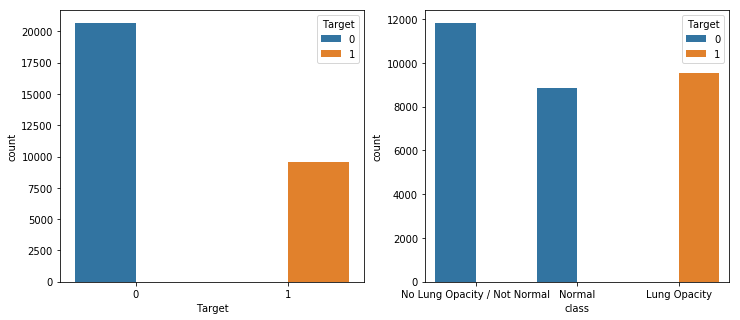

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# Count plot, x Target, color is target
sns.countplot(x = 'Target', hue = 'Target', data = df_dropdup,ax=axes[0])
sns.countplot(x = 'class', hue = 'Target', data = df_dropdup, ax=axes[1])
fig.savefig(os.path.join(visul_DIR,'Sample_target_class_count.png'), figdpi = 600)

#### 4) Prepare a dataframe df_box which includes bounding box information

##### Are there more than one row for one patient? 

In [11]:
#Group by patientId and count
print(df_dropdup['patientId'].value_counts().value_counts())

# check the head
print(df_dropdup['patientId'].value_counts().head(2))

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
Name: patientId, dtype: int64


##### Yes. Why? For Patients with Target = 1, there is additional information for bounding boxes 

In [12]:
box_counts = df_dropdup.groupby(['patientId','Target'])\
.size()\
.sort_values(ascending=False)\
.reset_index(name='boxes')
print(box_counts.head(2))

                              patientId  Target  boxes
0  7d674c82-5501-4730-92c5-d241fd6911e7       1      4
1  31764d54-ea3b-434f-bae2-8c579ed13799       1      4


In [13]:
df_box = pd.merge(df_dropdup, box_counts, on = ['patientId','Target'],how='left')
# Calculate the right and upper limit of boxes 
df_box['x_2'] = df_box['x'] + df_box['width']
df_box['y_2'] = df_box['y'] + df_box['height']
df_box['x_center'] = df_box['x'] + df_box['width'] / 2
df_box['y_center'] = df_box['y'] + df_box['height'] / 2
df_box['area'] = df_box['width'] * df_box['height']

print(df_box.head(2))
df_box.to_csv(os.path.join(procesed_data_DIR, 'df_train_labels_infor_boxes_merge.csv'), index = False)

                              patientId   x   y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0   

                          class  boxes  x_2  y_2  x_center  y_center  area  
0  No Lung Opacity / Not Normal      1  NaN  NaN       NaN       NaN   NaN  
1  No Lung Opacity / Not Normal      1  NaN  NaN       NaN       NaN   NaN  


In [14]:
box_count_sum = df_box.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')
print('Group by the number of boxes')
print(box_count_sum.head(5))
box_count_sum.to_csv(os.path.join(procesed_data_DIR,'df_boxe_count_sum.csv'), index = False)

Group by the number of boxes
   boxes  patients
0      1     23286
1      2      6532
2      3       357
3      4        52


#### 4.1) Let's check the sizes of bounding boxes 

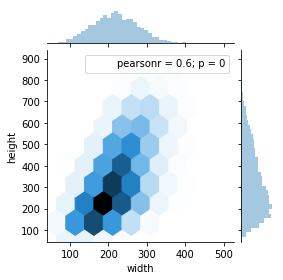

In [15]:
plot_box_size= sns.jointplot(x = 'width', y = 'height', data=df_box, kind ='hex', gridsize = 10,size =4)
plot_box_size.savefig(os.path.join(visul_DIR,'bounding_box_size.png'), figdpi = 600)

#### Where do the opacity regions are most likely to occur?

In [16]:
# select samples with Target ==1 
df_box_position = df_box.query('Target==1')
df_box_position.to_csv(os.path.join(procesed_data_DIR, 'df_box_position.csv'), index=False)
df_box_position.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 30226
Data columns (total 13 columns):
patientId    9555 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       9555 non-null int64
class        9555 non-null object
boxes        9555 non-null int64
x_2          9555 non-null float64
y_2          9555 non-null float64
x_center     9555 non-null float64
y_center     9555 non-null float64
area         9555 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 1.0+ MB


#### 4.2) Let's check the distribution of boxes

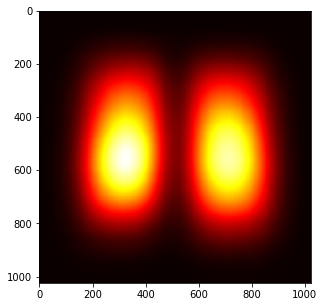

In [17]:
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
distribution_img = np.zeros_like(xx)
for _, c_row in df_box_position.iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    distribution_img += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (5, 5))
ax1.imshow(distribution_img, cmap='hot')
fig.savefig(os.path.join(visul_DIR,'bounding_box_distribution.png'), figdpi = 600)

#### 5) Prepare a dataframe df_sum including all the information (df_path, Target, class, and boxes)

In [18]:
df_sum = pd.merge(df_box,df_path, on ='patientId', how ='left').sort_values('patientId')
print(df_sum.head(2))
print(df_sum.shape[0],'images and segmentations')
df_sum.to_csv(os.path.join(procesed_data_DIR, 'df_train_labels_infor_boxes_path_merge.csv'), index = False)

                                  patientId   x   y  width  height  Target  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0   
28989  000924cf-0f8d-42bd-9158-1af53881a557 NaN NaN    NaN     NaN       0   

                              class  boxes  x_2  y_2  x_center  y_center  \
0      No Lung Opacity / Not Normal      1  NaN  NaN       NaN       NaN   
28989                        Normal      1  NaN  NaN       NaN       NaN   

       area                                               path  
0       NaN  /home/ubuntu/healthcare/pneumonia_lungfish/src...  
28989   NaN  /home/ubuntu/healthcare/pneumonia_lungfish/src...  
30227 images and segmentations


#### 6) Prepare a sample data set containing 6 samples (grouped by target, class and number or boxes)

In [19]:
df_sample = df_sum.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    sort_values(['Target','class','boxes'], ascending = True).\
    reset_index(drop=True)

print(df_sample['patientId'].nunique(), 'unique samples')
df_sample.to_csv(os.path.join(procesed_data_DIR, 'df_sample6.csv'),index = True)
df_sample

6 unique samples


,patientId,x,y,width,height,Target,class,boxes,x_2,y_2,x_center,y_center,area,path
0,327a4509-9929-41b6-9e3d-d2bd90117d90,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,NaN,NaN,NaN,NaN,NaN,/home/ubuntu/healthcare/pneumonia_lungfish/src...
1,81cc48ed-0b64-436e-809e-47c3fc35006f,NaN,NaN,NaN,NaN,0,Normal,1,NaN,NaN,NaN,NaN,NaN,/home/ubuntu/healthcare/pneumonia_lungfish/src...
2,342bd0cf-b337-40e9-8512-eb170292e2f2,317.0,519.0,121.0,127.0,1,Lung Opacity,1,438.0,646.0,377.5,582.5,15367.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...
3,94c4e247-1228-4f50-b8b4-316754d5828f,391.0,357.0,194.0,222.0,1,Lung Opacity,2,585.0,579.0,488.0,468.0,43068.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...
4,94c4e247-1228-4f50-b8b4-316754d5828f,696.0,405.0,202.0,280.0,1,Lung Opacity,2,898.0,685.0,797.0,545.0,56560.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...
5,085a6486-c3b3-4ca2-80f1-be07d23e853b,665.0,231.0,185.0,284.0,1,Lung Opacity,3,850.0,515.0,757.5,373.0,52540.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...
6,085a6486-c3b3-4ca2-80f1-be07d23e853b,147.0,325.0,158.0,225.0,1,Lung Opacity,3,305.0,550.0,226.0,437.5,35550.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...
7,085a6486-c3b3-4ca2-80f1-be07d23e853b,332.0,422.0,155.0,249.0,1,Lung Opacity,3,487.0,671.0,409.5,546.5,38595.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...
8,32408669-c137-4e8d-bd62-fe8345b40e73,273.0,856.0,234.0,101.0,1,Lung Opacity,4,507.0,957.0,390.0,906.5,23634.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...
9,32408669-c137-4e8d-bd62-fe8345b40e73,702.0,801.0,249.0,144.0,1,Lung Opacity,4,951.0,945.0,826.5,873.0,35856.0,/home/ubuntu/healthcare/pneumonia_lungfish/src...


## II. EDA of Images

#### 1) How does a pneumonia DICOM image look like?

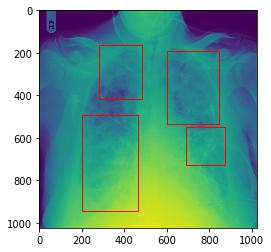

In [20]:
# check an image with 4 boxes from the sample data set
file = pydicom.read_file(os.path.join(train_dicom_DIR,'8dc8e54b-5b05-4dac-80b9-fa48878621e2.dcm'))
#pt.imshow(file.pixel_array, cmap=plt.cm.bone) 
im = file.pixel_array
# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(im)

# Add bounding boxes 
# Create a Rectangle patch (xy, width, height)
rect1 = patches.Rectangle((602,189),245,347,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((199,492),267,452,linewidth=1,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((281,163),201,253, linewidth=1,edgecolor='r',facecolor='none')
rect4 = patches.Rectangle((688,548),187,181,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.show()
fig.savefig(os.path.join(visul_DIR,'8dc8e54b-5b05-4dac-80b9-fa48878621e2_postive_sampe.png'), figdpi = 600)


#### 2) Let's check a negative case 

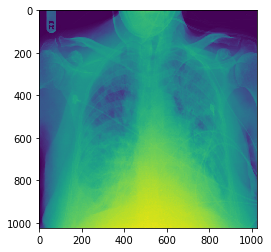

In [21]:
#doc
neg = pydicom.read_file(os.path.join(train_dicom_DIR,'5e01e86a-d042-4644-a101-359fc9c8f59e.dcm'))
#plt.imshow(file.pixel_array, cmap=plt.cm.bone) 
im2 = neg.pixel_array
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
# Add the patch to the Axes

plt.show()
fig.savefig(os.path.join(visul_DIR,'5e01e86a-d042-4644-a101-359fc9c8f59e_negative_sampe.png'), figdpi = 600)


#### 3) Overlay the distribution of boxes with 6 patients' images, and bounding boxes

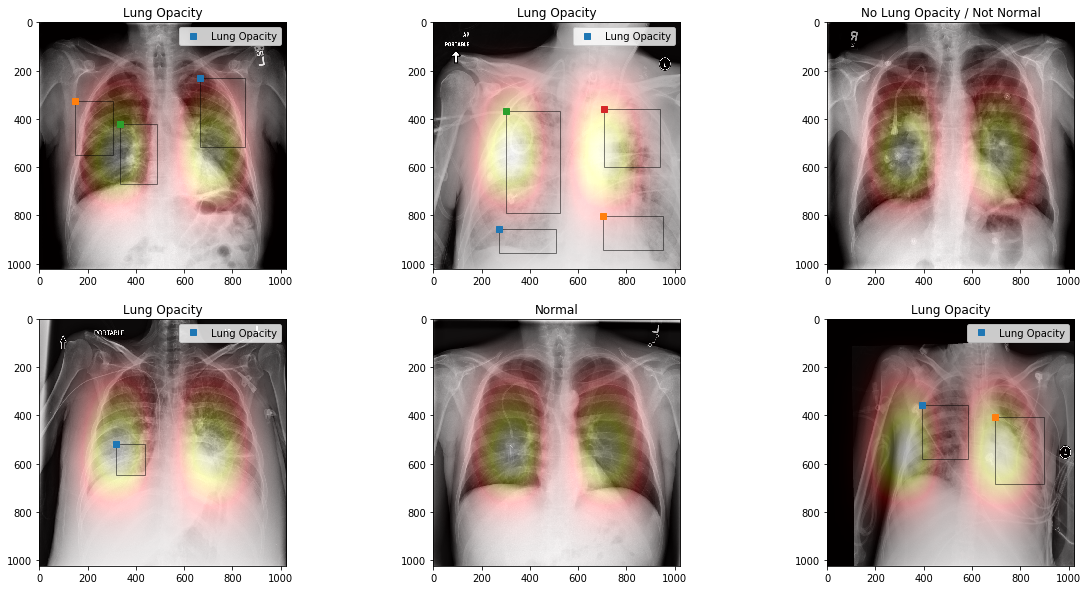

In [22]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))

for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    df_sample.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(distribution_img/distribution_img.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(patches.Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
            
fig.savefig(os.path.join(visul_DIR,'6sample_distribution_boxes.png'), figdpi = 600)

## III Model

#### Transfer learning using MASK_RCNN  

#### Download and setup 
os.chdir('/home/ubuntu/healthcare/pneumonia_lungfish/src/')  
!git clone https://www.github.com/matterport/Mask_RCNN.git  
sys.path.append(os.path.join(src, 'Mask_RCNN'))  
os.chdir('Mask_RCNN/')  
!python setup.py -q install

In [5]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib

from mrcnn import visualize
from mrcnn.model import log

#### 1) Some setup functions and classes for Mask-RCNN
* train_dicom is a list of the dicom image path and filenames
* image_annotions is a dictionary of the annotations keyed by the filenames
* parsing the dataset returns a list of the image filenames and the annotations dictionary


In [83]:
def get_train_dicom(dicom_dir):
    train_dicom = glob.glob(dicom_dir+'/'+'*.dcm') #a list of the dicom image path and filenames
    return list(set(train_dicom))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_train_dicom(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps} #a dictionary of the annotations keyed by the filenames
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId'] + '.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [7]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [8]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)


#### 2) Match training csv and images 

In [9]:
df_sum = pd.read_csv(os.path.join(procesed_data_DIR, 'df_train_labels_infor_boxes_path_merge.csv'))
df_sum.head(2)

,patientId,x,y,width,height,Target,class,boxes,x_2,y_2,x_center,y_center,area,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,NaN,NaN,NaN,NaN,NaN,/home/ubuntu/healthcare/pneumonia_lungfish/src...
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,NaN,NaN,NaN,NaN,NaN,/home/ubuntu/healthcare/pneumonia_lungfish/src...


In [10]:
image_fps, image_annotations = parse_dataset(train_dicom_DIR, anns=df_sum)

#### 3） Prepare a sample image dataset for demo

In [12]:
image_fps_list_sample = list(image_fps[:1000]) 

#### 3.2) Split the dataset into train, validation and test (0.8:0.1:0.1)

In [13]:
def image_split(image_list, small_dataset_ratio):
    split_index = int((1 - float(small_dataset_ratio)) * len(image_list))
    
    sorted(image_list)
    random.seed(42)
    random.shuffle(image_list)
    
    image_fps_big = image_list[:split_index]
    image_fps_small = image_list[split_index:]
    return image_fps_big, image_fps_small    

In [14]:
# Split the sample image list into train vs val_test
image_fps_train, image_fps_val_test = image_split(image_fps_list_sample, 0.2)
print('train:',len(image_fps_train), ';', 'validation and test: ', len(image_fps_val_test))

# Split the val_test into validation and test
image_fps_val, image_fps_test = image_split(image_fps_val_test, 0.5)
print('validataion: ',len(image_fps_val), ';',' test: ', len(image_fps_test))

train: 800 ; validation and test:  200
validataion:  100 ;  test:  100


#### 3.2) prepare the training dataset

In [15]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId                 6d6c53eb-4b90-4149-a8f4-523b65375525
 x                                                          NaN
 y                                                          NaN
 width                                                      NaN
 height                                                     NaN
 Target                                                       0
 class                             No Lung Opacity / Not Normal
 boxes                                                        1
 x_2                                                        NaN
 y_2                                                        NaN
 x_center                                                   NaN
 y_center                                                   NaN
 area                                                       NaN
 path         /home/ubuntu/healthcare/pneumonia_lungfish/src...
 Name: 11380, dtype: object]

#### 3.3 ) Training

In [16]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)

# Exclude the last layers because they require a matching

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

In [18]:
%%time

## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE*6,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no augmentation



Starting at epoch 0. LR=0.006

Checkpoint Path: /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190305T0854/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

In [23]:
history = model.keras_model.history.history
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.847040,0.576924,0.263628,0.462029,0.520016,0.024441,2.348162,0.582427,0.143499,0.431904,1.171724,0.018607
2,1.616993,0.457198,0.230507,0.407543,0.504375,0.017369,1.821725,0.629243,0.296598,0.434861,0.443665,0.017357


model.get_trainable_layers()# 71 layers

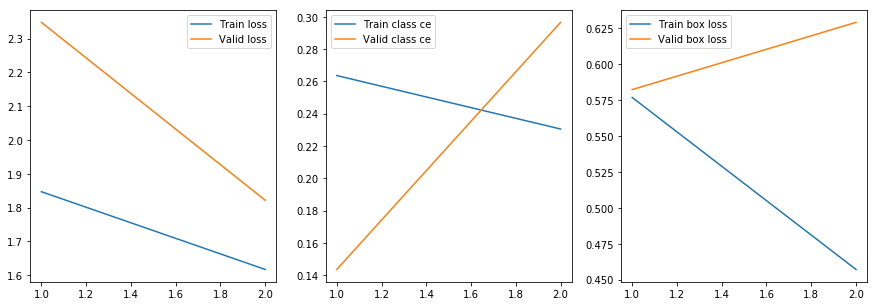

In [75]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()


#### 3.4 ) Inference

In [77]:
model_path = os.path.join(models_working_DIR,'pneumonia20190305T0854','mask_rcnn_pneumonia_0002.h5')

In [78]:
model_path

'/home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190305T0854/mask_rcnn_pneumonia_0002.h5'

In [79]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=models_save_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190305T0854/mask_rcnn_pneumonia_0002.h5
Re-starting from epoch 2


In [80]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 

30

*** No instances to display *** 

35

*** No instances to display *** 

85

*** No instances to display *** 

62

*** No instances to display *** 

27

*** No instances to display *** 

69


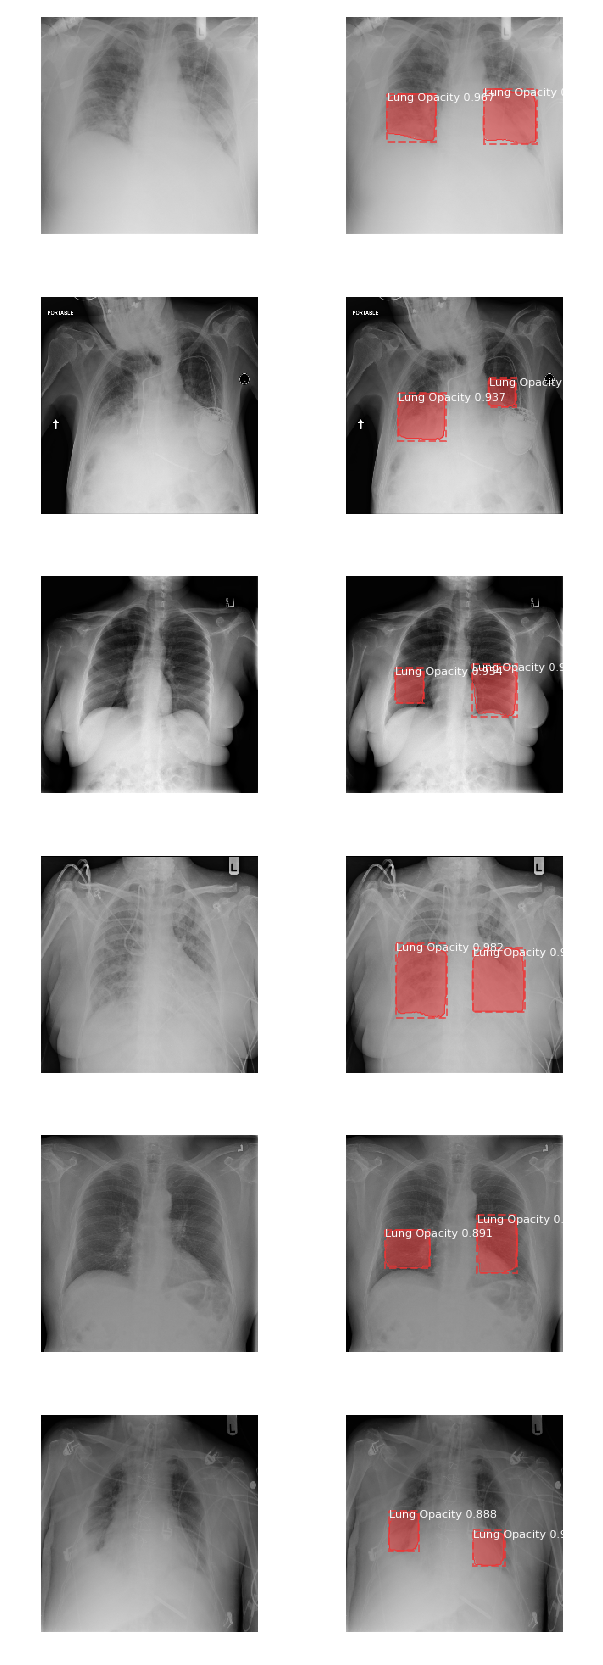

In [95]:
#show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    #print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    print(image_id)

original_image,image_meta is an arry
gt_class_id: array([1], dtype=int32)
gt_bbox: gt_bbox
gt_mask: array False
dataset.class_names
gt_class_id: array([1], dtype=int32)

{'rois': array([[149, 176, 183, 212],
        [139,  47, 167,  82]], dtype=int32),
 'class_ids': array([1, 1], dtype=int32),
 'scores': array([0.9235355 , 0.86759233], dtype=float32),
 'masks': array([[[False, False],

#### 3.5) Evaluation metrics 

#### add to utils.py

#### 4) Training with full dataset Trin: Validation: Test =0.9:0.05

In [183]:
image_fps_list = list(image_fps) 

In [184]:
# Split the sample image list into train vs val_test
image_fps_train, image_fps_val_test = image_split(image_fps_list, 0.1)
print('train:',len(image_fps_train), ';', 'validation and test: ', len(image_fps_val_test))

# Split the val_test into validation and test
image_fps_val, image_fps_test = image_split(image_fps_list, 0.5)
print('validataion: ',len(image_fps_val), ';',' test: ', len(image_fps_test))

train: 24015 ; validation and test:  2669
validataion:  13342 ;  test:  13342


In [185]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId                 72ae200d-3259-430f-80e7-7126da98a255
 x                                                          NaN
 y                                                          NaN
 width                                                      NaN
 height                                                     NaN
 Target                                                       0
 class                                                   Normal
 boxes                                                        1
 x_2                                                        NaN
 y_2                                                        NaN
 x_center                                                   NaN
 y_center                                                   NaN
 area                                                       NaN
 path         /home/ubuntu/healthcare/pneumonia_lungfish/src...
 Name: 12069, dtype: object]

#### 4.3)  Training

In [186]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)

# Exclude the last layers because they require a matching

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

In [187]:
%%time

## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE*6,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no augmentation



Starting at epoch 0. LR=0.006

Checkpoint Path: /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190305T1214/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

In [188]:
history = model.keras_model.history.history
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.824040,0.559363,0.286837,0.420901,0.529875,0.027062,2.246616,0.662307,0.404207,0.441715,0.714936,0.023450
2,1.528766,0.440333,0.168665,0.390015,0.514051,0.015700,1.607684,0.473274,0.248791,0.422864,0.442977,0.019775


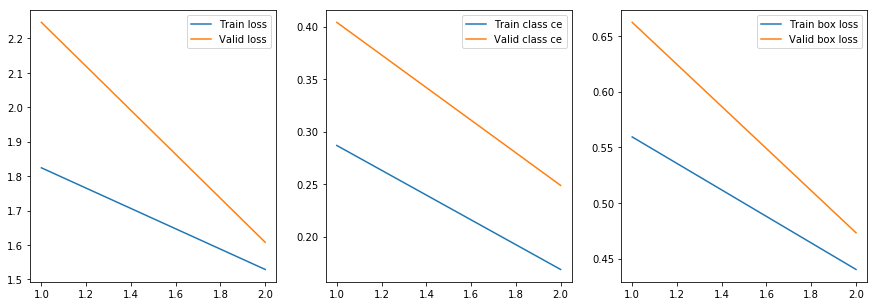

In [189]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()


#### 4) Inference 

In [ ]:
model_path = os.path.join(models_working_DIR,'pneumonia20190305T0854','mask_rcnn_pneumonia_0002.h5')

In [190]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 2 1.607683655023575


In [191]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=models_save_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190305T0854/mask_rcnn_pneumonia_0002.h5
Re-starting from epoch 2



*** No instances to display *** 

24

*** No instances to display *** 

3410
12474

*** No instances to display *** 

3568

*** No instances to display *** 

32

*** No instances to display *** 

998


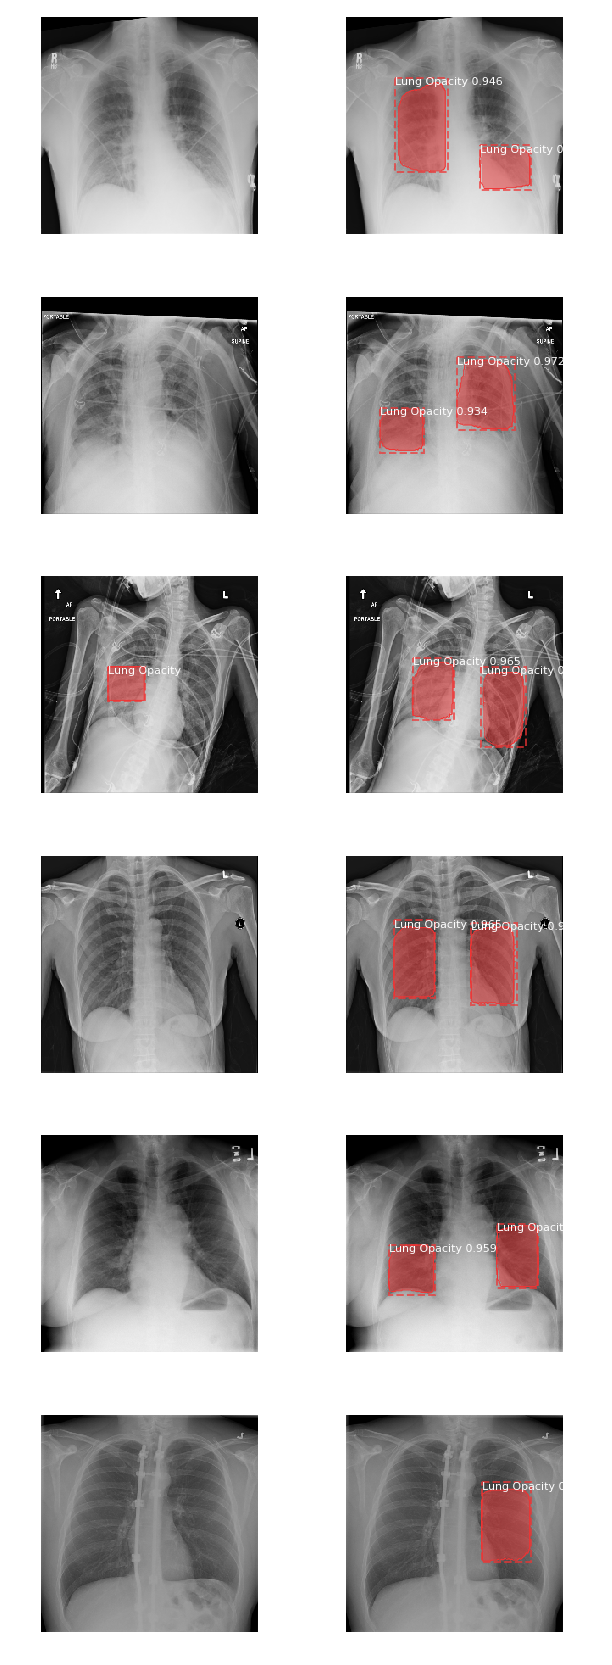

In [192]:
#show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    #print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    print(image_id)

### Select trained model 

Reference 
https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb#scrollTo=8EBVA1M60yAj

https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155

https://www.kaggle.com/kmader/lung-opacity-overview

https://www.kaggle.com/aantonova/attempt-of-metric-s-implementation

## Error